In [1]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as utils

import helper

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import norm

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
biwi = pd.read_csv('./data/train/biwi/biwi_hotel.txt', header = None,
                 names = ['frameNb','id', 'x','y'],delimiter=' ')
id_unique = np.unique(np.array(biwi['id']))

init = np.zeros(len(biwi)) 
biwi['Speed'] = init
biwi['Angle'] = init
biwi['Vx'] = init
biwi['Vy'] = init

In [4]:
pd.options.mode.chained_assignment = None ## Disable StettingWithCopy warning
c = 0
for i in id_unique:
    a = biwi[biwi['id']==i]
    ind = a.index
    a.index = range(len(a))
    dist = a['x'].iloc
    dist1 = a.loc[0:len(a)-2,'x':'y']
    dist1.index=range(len(dist1))
    dist2 = a.loc[1:,'x':'y']
    dist2.index=range(len(dist2))
    dist = dist2-dist1
    b = len(dist)
    if c < b:
        vector_speed = np.zeros((len(id_unique),b,2))
        c=b
b = 0
for i in id_unique:
    a = biwi[biwi['id']==i]
    ind = a.index
    a.index = range(len(a))
    dist = a['x'].iloc
    dist1 = a.loc[0:len(a)-2,'x':'y']
    dist1.index=range(len(dist1))
    dist2 = a.loc[1:,'x':'y']
    dist2.index=range(len(dist2))
    dist = dist2-dist1
    speed = np.array(np.sqrt(dist['x']**2+dist['y']**2)/0.4)
    biwi.loc[ind[1:],'Speed'] = speed
    angle=np.zeros(len(dist)-1)
    vx=np.zeros(len(dist))
    vy=np.zeros(len(dist))
    for j in range(len(dist)-1):
        if norm(dist.loc[j,:])==0 or norm(dist.loc[j+1,:])==0:
            angle[j]=0
        elif np.cross(dist.loc[j,:],dist.loc[j+1,:])/(norm(dist.loc[j,:])*norm(dist.loc[j+1,:]))>1:
            angle[j]=np.arcsin(1)
        else:
            angle[j]=np.arcsin(np.cross(dist.loc[j,:],dist.loc[j+1,:])/(norm(dist.loc[j,:])*norm(dist.loc[j+1,:])))
    
    for j in range(len(dist)):
        if j == 0:
            vx[j] = 0
            vy[j] = speed[j]
            vector_speed[b][j][0]=vx[j]
            vector_speed[b][j][1]=vy[j]
        else:
            vx[j] = speed[j]*np.sin(sum(angle[:j]))
            vy[j] = speed[j]*np.cos(sum(angle[:j]))
            vector_speed[b][j][0]=vx[j]
            vector_speed[b][j][1]=vy[j]
    
    biwi.loc[ind[2:],'Angle'] = angle
    biwi.loc[ind[1:],'Vx'] = vx
    biwi.loc[ind[1:],'Vy'] = vy
    b+=1

In [5]:
vector = np.zeros((len(vector_speed),2*len(vector_speed[0])))
x = np.zeros((len(vector_speed),18))
y = np.zeros((len(vector_speed),18))
x_train = np.zeros((len(vector_speed)-20,18))
Y_train = np.zeros((len(vector_speed)-20,18))
x_val = np.zeros((20,18))
y_val = np.zeros((20,18))

for i in range(len(vector_speed)):
    vector[i][:] = np.reshape(vector_speed[i][:][:],2*19,'C')
for i in range(len(vector)):
    x[i][:] = vector[i][:18]
    y[i][:] = vector[i][20:38]

mask = list(range(len(vector)-20, len(vector)))
x_val = x[mask]
y_val = y[mask]
mask = list(range(len(vector)-20))
x_train = x[mask]
y_train = y[mask]

x_train,y_train = torch.from_numpy(x_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.FloatTensor)
x_val,y_val = torch.from_numpy(x_val).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.FloatTensor)

x_train = x_train.unsqueeze(1) # add 1 dimension to the training set
y_train = y_train.unsqueeze(1) # add 1 dimension to the training set
x_val = x_val.unsqueeze(1) # add 1 dimension to the validation set
y_val = y_val.unsqueeze(1) # add 1 dimension to the validation set

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)

traindataset = utils.TensorDataset(x_train, y_train)
trainloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

valdataset = utils.TensorDataset(x_val, y_val)
valloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

Train data shape:  torch.Size([125, 1, 18])
Train labels shape:  torch.Size([125, 1, 18])
Validation data shape:  torch.Size([20, 1, 18])
Validation labels shape:  torch.Size([20, 1, 18])


In [20]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=1, n_output=None):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        self.conv1 = nn.Conv1d(n_input_channels,8,5,padding=2)
        self.conv2 = nn.Conv1d(8,30,3,padding=1)
        self.conv3 = nn.Conv1d(30,40,3,padding=1)
        self.conv3_bn = nn.BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True)
     
        self.fc1 = nn.Linear(9*2 * 40, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 18)
        
        
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Variable `x` with `x.view`.                                                  #
        ################################################################################
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.view(-1, 9*2 * 40) # in order to reshape the tensor for as many columns we need
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

/Users/4romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/20.. Loss: 0.2217.. Test accuracy: 0.0204.. 0.0117 s/batch  steps 1.0000
Epoch: 1/20.. Loss: 0.4272.. Test accuracy: 0.0232.. 0.0108 s/batch  steps 2.0000
Epoch: 1/20.. Loss: 0.5980.. Test accuracy: 0.0084.. 0.0105 s/batch  steps 3.0000
Epoch: 1/20.. Loss: 0.7451.. Test accuracy: 0.0374.. 0.0105 s/batch  steps 4.0000
Epoch: 1/20.. Loss: 0.3721.. Test accuracy: 0.0144.. 0.0090 s/batch  steps 5.0000
Epoch: 1/20.. Loss: 0.8113.. Test accuracy: 0.0351.. 0.0091 s/batch  steps 6.0000
Epoch: 1/20.. Loss: 0.8820.. Test accuracy: 0.0255.. 0.0115 s/batch  steps 7.0000
Epoch: 1/20.. Loss: 0.6723.. Test accuracy: 0.0232.. 0.0099 s/batch  steps 8.0000
Epoch: 1/20.. Loss: 0.3394.. Test accuracy: 0.0167.. 0.0121 s/batch  steps 9.0000
Epoch: 1/20.. Loss: 0.3175.. Test accuracy: 0.0223.. 0.0142 s/batch  steps 10.0000
Epoch: 1/20.. Loss: 0.3264.. Test accuracy: 0.0269.. 0.0111 s/batch  steps 11.0000
Epoch: 1/20.. Loss: 0.3201.. Test accuracy: 0.0016.. 0.0142 s/batch  steps 12.0000
Epoch: 1/20..

Epoch: 5/20.. Loss: 0.1375.. Test accuracy: 0.0328.. 0.0102 s/batch  steps 101.0000
Epoch: 5/20.. Loss: 0.0573.. Test accuracy: 0.0107.. 0.0105 s/batch  steps 102.0000
Epoch: 5/20.. Loss: 0.0466.. Test accuracy: 0.0169.. 0.0112 s/batch  steps 103.0000
Epoch: 5/20.. Loss: 0.1318.. Test accuracy: 0.0302.. 0.0098 s/batch  steps 104.0000
Epoch: 5/20.. Loss: 0.0889.. Test accuracy: 0.0261.. 0.0134 s/batch  steps 105.0000
Epoch: 5/20.. Loss: 0.0295.. Test accuracy: 0.0239.. 0.0156 s/batch  steps 106.0000
Epoch: 5/20.. Loss: 0.1150.. Test accuracy: 0.0173.. 0.0112 s/batch  steps 107.0000
Epoch: 5/20.. Loss: 0.0325.. Test accuracy: 0.0202.. 0.0110 s/batch  steps 108.0000
Epoch: 5/20.. Loss: 0.0147.. Test accuracy: 0.0289.. 0.0104 s/batch  steps 109.0000
Epoch: 5/20.. Loss: 0.0513.. Test accuracy: 0.0349.. 0.0119 s/batch  steps 110.0000
Epoch: 5/20.. Loss: 0.0565.. Test accuracy: 0.0196.. 0.0108 s/batch  steps 111.0000
Epoch: 5/20.. Loss: 0.0487.. Test accuracy: 0.0255.. 0.0113 s/batch  steps 1

Epoch: 8/20.. Loss: 0.0341.. Test accuracy: 0.0327.. 0.0121 s/batch  steps 199.0000
Epoch: 8/20.. Loss: 0.0649.. Test accuracy: 0.0328.. 0.0130 s/batch  steps 200.0000
Epoch: 9/20.. Loss: 0.1328.. Test accuracy: 0.0151.. 0.0132 s/batch  steps 201.0000
Epoch: 9/20.. Loss: 0.1198.. Test accuracy: 0.0167.. 0.0120 s/batch  steps 202.0000
Epoch: 9/20.. Loss: 0.0339.. Test accuracy: 0.0391.. 0.0122 s/batch  steps 203.0000
Epoch: 9/20.. Loss: 0.0184.. Test accuracy: 0.0294.. 0.0126 s/batch  steps 204.0000
Epoch: 9/20.. Loss: 0.0281.. Test accuracy: 0.0302.. 0.0117 s/batch  steps 205.0000
Epoch: 9/20.. Loss: 0.0452.. Test accuracy: 0.0028.. 0.0107 s/batch  steps 206.0000
Epoch: 9/20.. Loss: 0.0544.. Test accuracy: 0.0295.. 0.0141 s/batch  steps 207.0000
Epoch: 9/20.. Loss: 0.0726.. Test accuracy: 0.0201.. 0.0132 s/batch  steps 208.0000
Epoch: 9/20.. Loss: 0.0435.. Test accuracy: 0.0268.. 0.0125 s/batch  steps 209.0000
Epoch: 9/20.. Loss: 0.0179.. Test accuracy: 0.0252.. 0.0120 s/batch  steps 2

Epoch: 12/20.. Loss: 0.0174.. Test accuracy: 0.0376.. 0.0120 s/batch  steps 297.0000
Epoch: 12/20.. Loss: 0.0179.. Test accuracy: 0.0052.. 0.0145 s/batch  steps 298.0000
Epoch: 12/20.. Loss: 0.0355.. Test accuracy: 0.0209.. 0.0130 s/batch  steps 299.0000
Epoch: 12/20.. Loss: 0.0469.. Test accuracy: 0.0228.. 0.0135 s/batch  steps 300.0000
Epoch: 13/20.. Loss: 0.0512.. Test accuracy: 0.0257.. 0.0121 s/batch  steps 301.0000
Epoch: 13/20.. Loss: 0.0153.. Test accuracy: 0.0331.. 0.0125 s/batch  steps 302.0000
Epoch: 13/20.. Loss: 0.0244.. Test accuracy: 0.0238.. 0.0117 s/batch  steps 303.0000
Epoch: 13/20.. Loss: 0.0164.. Test accuracy: 0.0151.. 0.0122 s/batch  steps 304.0000
Epoch: 13/20.. Loss: 0.0806.. Test accuracy: 0.0144.. 0.0144 s/batch  steps 305.0000
Epoch: 13/20.. Loss: 0.0179.. Test accuracy: 0.0326.. 0.0125 s/batch  steps 306.0000
Epoch: 13/20.. Loss: 0.0903.. Test accuracy: 0.0245.. 0.0151 s/batch  steps 307.0000
Epoch: 13/20.. Loss: 0.0141.. Test accuracy: 0.0246.. 0.0135 s/ba

Epoch: 16/20.. Loss: 0.0372.. Test accuracy: 0.0322.. 0.0145 s/batch  steps 397.0000
Epoch: 16/20.. Loss: 0.0284.. Test accuracy: 0.0092.. 0.0137 s/batch  steps 398.0000
Epoch: 16/20.. Loss: 0.0253.. Test accuracy: 0.0324.. 0.0133 s/batch  steps 399.0000
Epoch: 16/20.. Loss: 0.0643.. Test accuracy: 0.0362.. 0.0133 s/batch  steps 400.0000
Epoch: 17/20.. Loss: 0.0234.. Test accuracy: 0.0209.. 0.0132 s/batch  steps 401.0000
Epoch: 17/20.. Loss: 0.0576.. Test accuracy: 0.0130.. 0.0140 s/batch  steps 402.0000
Epoch: 17/20.. Loss: 0.0208.. Test accuracy: 0.0088.. 0.0147 s/batch  steps 403.0000
Epoch: 17/20.. Loss: 0.0323.. Test accuracy: 0.0272.. 0.0106 s/batch  steps 404.0000
Epoch: 17/20.. Loss: 0.0226.. Test accuracy: 0.0210.. 0.0130 s/batch  steps 405.0000
Epoch: 17/20.. Loss: 0.0214.. Test accuracy: 0.0153.. 0.0117 s/batch  steps 406.0000
Epoch: 17/20.. Loss: 0.0262.. Test accuracy: 0.0095.. 0.0126 s/batch  steps 407.0000
Epoch: 17/20.. Loss: 0.0145.. Test accuracy: 0.0141.. 0.0112 s/ba

Epoch: 20/20.. Loss: 0.0306.. Test accuracy: 0.0264.. 0.0155 s/batch  steps 496.0000
Epoch: 20/20.. Loss: 0.0300.. Test accuracy: 0.0183.. 0.0166 s/batch  steps 497.0000
Epoch: 20/20.. Loss: 0.0273.. Test accuracy: 0.0324.. 0.0141 s/batch  steps 498.0000
Epoch: 20/20.. Loss: 0.0395.. Test accuracy: 0.0234.. 0.0139 s/batch  steps 499.0000
Epoch: 20/20.. Loss: 0.0157.. Test accuracy: 0.0274.. 0.0141 s/batch  steps 500.0000


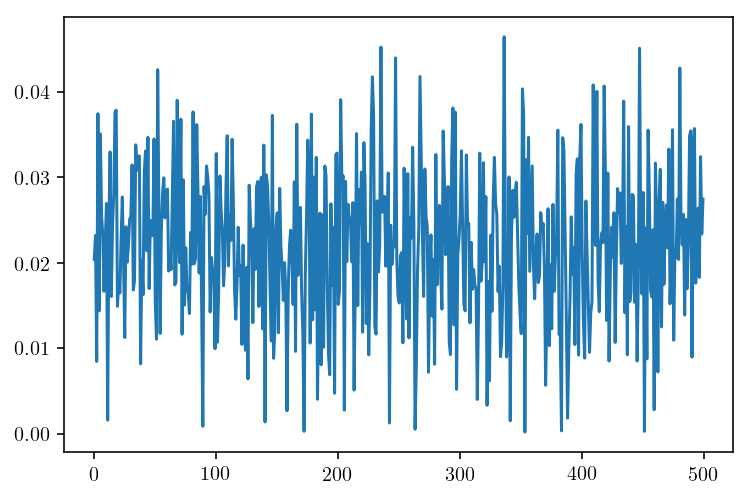

In [22]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
epochs = 20
steps = 0
running_loss = 0
print_every = 1
vec_acc_ = np.zeros(epochs*25)
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Do not forget to transform the inputs and outputs into Variable        #
        # which pytorch uses.                                                          #
        ################################################################################
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        output = net.forward(inputs)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        grad = loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                inputs = Variable(images)
                targets = Variable(labels)
                predicted = net.predict(inputs)
                accuracy = criterion(predicted, targets)
                accuracy = accuracy.data.numpy().tolist()[0]
                vec_acc_[steps-1] = accuracy/(ii+1)
                
                #inputs = Variable(images, volatile=True)
                #predicted = net.predict(inputs)
                #equality = (labels == predicted.max(1)[1])
                #accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                
                #im = Variable(images)
                #out = net.predict(im)
                #_,prediction = torch.max(out, 1)
                #pred_y = prediction.data.numpy().squeeze()
                #target_y = labels.numpy()
                #accuracy = np.mean(predicted == inputs)
                #print(pred_y.shape,target_y.shape)
                
                
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(loss.data[0]),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                  "steps {:.4f}".format(steps)
                 )
            running_loss = 0
            start = time.time()

plt.plot(range(epochs*25),vec_acc_)
plt.show()

In [27]:
vec_acc_

array([0.01840553, 0.00550009, 0.00587005, 0.02756201, 0.0284391 ,
       0.01824291, 0.02176573, 0.0349001 , 0.0385395 , 0.00823474,
       0.02325155, 0.03199237, 0.01350757, 0.02789121, 0.02472419,
       0.0150252 , 0.02402565, 0.02020308, 0.02602012, 0.01936461,
       0.00418759, 0.00688567, 0.03759749, 0.02734746, 0.02060748])

In [94]:
targets

Variable containing:
(0 ,.,.) = 

Columns 0 to 8 
   0.0000  0.0000  0.0000  0.1820 -0.0069  0.0240 -0.0000  0.0000 -0.0000

Columns 9 to 17 
   0.0000 -0.0343  0.1202 -0.1133  0.3056 -0.0790  0.1854 -0.0069  0.0240

(1 ,.,.) = 

Columns 0 to 8 
  -0.0484  1.6810  0.0544  1.7249  0.1391  1.4693 -0.1512  1.6371  0.1308

Columns 9 to 17 
   1.7453  0.2216  1.5895 -0.1762  1.6387  0.3993  1.6288  0.1376  1.4443

(2 ,.,.) = 

Columns 0 to 8 
  -0.7916  1.1444 -0.5575  1.3200 -0.5190  1.2794 -0.6314  1.2192 -0.4451

Columns 9 to 17 
   1.3802 -0.5596  1.2410 -0.6553  1.2119 -0.5720  1.3678 -0.7510  1.1829

(3 ,.,.) = 

Columns 0 to 8 
   0.0968  0.5160  0.3793  0.6665  0.4730  0.6235  0.0015  0.6865 -0.0307

Columns 9 to 17 
   0.5145  0.2411  0.7433  0.3210  0.6266  0.0722  0.5206 -0.0323  0.6419

(4 ,.,.) = 

Columns 0 to 8 
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 9 to 17 
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
